In [1]:
import numpy as np
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.document_loaders import PyPDFLoader
from langchain_openai import OpenAIEmbeddings
from mol_tools.tools import QaAgent, SmilesFilter, SMILESEnergyPredictionTool
from langchain_openai import ChatOpenAI
from dotenv import find_dotenv, load_dotenv
import logging

In [2]:
# set up
logging.basicConfig(level=logging.INFO)
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
llm = ChatOpenAI(model_name="gpt-3.5-turbo") 
embeddings_provider = OpenAIEmbeddings(model="text-embedding-3-small")
# loader = WebBaseLoader("https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8264982/")
loader = PyPDFLoader("storage/13045_2021_Article_1121.pdf")
docs = loader.load() 
text = " ".join([page.page_content for page in docs])

# Part 1: Custom Retriever Tool Development

#### Ask questions about the paper

In [8]:
questions = [
    "What disease are they discussing in the paper?",
    "Summarize the main takeaways from the paper.",
    "Can you list the protein targets they highlight in the paper?",
    "Can you list the small molecule drugs they highlight in the paper?",
]

In [10]:
qa = QaAgent(
        docs, llm, embeddings_provider, vector_path="storage/PMC8264982.faiss"
    )
for q in questions:
    print("Question:", q, "\n Answer:", qa.answer(q))

Question: What disease are they discussing in the paper? 
 Answer: The paper discusses advanced non-small cell lung cancer (NSCLC).
Question: Summarize the main takeaways from the paper. 
 Answer: The paper discusses the importance of predictive biomarkers in advanced non-small cell lung cancer (NSCLC), focusing on EGFR mutations as oncogenic drivers in a subset of patients. The use of EGFR inhibitors, such as osimertinib, is highlighted as standard of care in the first-line metastatic setting for untreated EGFR mutant NSCLC. Resistance mechanisms to EGFR TKIs, including acquired resistance and treatment options after progression on osimertinib, are also discussed. Ongoing clinical trials, such as ORCHARD, Checkmate 722, and KEYNOTE-789, are exploring optimal treatment strategies for patients with EGFR-mutant NSCLC based on their underlying resistance mechanisms. The distribution of actionable mutations in advanced lung adenocarcinoma, along with available targeted therapies and their 

#### Search for SMILES strings

In [3]:
%%capture
smiles_filter = SmilesFilter()
text = " ".join([page.page_content for page in docs])
smiles_tokens = smiles_filter.filter(text)

INFO:root:Processing 13598 tokens


In [5]:
print("SMILES tokens:", smiles_tokens)

SMILES tokens: ['I/II', 'I/II', 'I/II', 'II', 'III', 'III', 'I/II', 'II', 'II', 'IIB', 'CI', 'II', 'I/II', 'I/II', 'CNS', 'II', 'PPP', 'CI', 'CI', 'CI', 'CI', 'I/II', '\nCNS', 'I/II', 'CNS', 'I/II', '\nI', 'I/II', 'III', 'I/II', '\nOS', 'I/II', 'II', 'CI', 'I/II', 'I/II', 'II', 'II', 'CI', 'I/II', '\nI/II', 'III', 'I/II', 'I/II', 'II', 'IB', 'I/II', 'I/II', '\nI/II', 'CI', 'CI', 'I-II', 'CI', 'II', 'I/II', 'II', 'CI', 'I/II', 'CNS', 'II', 'I/II', 'OS', 'III', 'II', 'I/II', 'III', 'I/II', 'I/II', 'I/II', 'I/II', 'I/II', 'II', 'I/II', 'I/II', 'I/II', 'I/II', 'I/II', '\nI/II', '\nNCCN', '\nII', 'CI', 'CI', 'CI', 'II', 'I/II', 'I/II', 'I/II', 'I/II', 'II', 'CNS', 'II', 'II', 'III', 'I/II', 'III', '\nI/II', 'I/II', 'II', 'I/II', 'II', 'II']


# Part 2: Predictive Machine Learning Model Tooling Implementation

#### Trian a model (Regression)

In [12]:
from mol_tools.trainer import train
from sklearn.metrics import mean_absolute_error
from mol_tools.data_utils import get_freesolv_data
X_train, X_test, y_train, y_test = get_freesolv_data()
mlp_model = train(X_train, y_train, model= "mlp_regression")
tree_regressor = train(X_train, y_train, model="tree_regression")
ensamble_regressor = train(X_train, y_train, model="AutoSklearnRegressor")
models = {"mlp": mlp_model, "tree": tree_regressor, "ensamble": ensamble_regressor}

/home/v-oostapenko/miniconda3/envs/vllns/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


<Axes: >

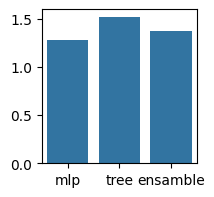

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
results = {}
for model in models:
    y_hat = models[model].predict(X_test)
    mae = mean_absolute_error(y_test, y_hat)
    results[model] = mae
# barplot
# small size 
plt.figure(figsize=(2, 2))
sns.barplot(x=list(results.keys()), y=list(results.values()))
    

Here, MLP seems like the best model, lets stick to it.

### Use the model to make poreditions for SMILEs tokens discovered above

In [7]:

from mol_tools.data_utils import get_freesolv_data
X_train, X_test, y_train, y_test = get_freesolv_data()

In [8]:
smiles_tokens = ['I/II', 'I/II', 'I/II', 'II', 'III', 'III', 'I/II', 'II', 'II', 'IIB', 'CI', 'II', 'I/II', 'I/II', 'CNS', 'II', 'PPP', 'CI', 'CI', 'CI', 'CI', 'I/II', '\nCNS', 'I/II', 'CNS', 'I/II', '\nI', 'I/II', 'III', 'I/II', '\nOS', 'I/II', 'II', 'CI', 'I/II', 'I/II', 'II', 'II', 'CI', 'I/II', '\nI/II', 'III', 'I/II', 'I/II', 'II', 'IB', 'I/II', 'I/II', '\nI/II', 'CI', 'CI', 'I-II', 'CI', 'II', 'I/II', 'II', 'CI', 'I/II', 'CNS', 'II', 'I/II', 'OS', 'III', 'II', 'I/II', 'III', 'I/II', 'I/II', 'I/II', 'I/II', 'I/II', 'II', 'I/II', 'I/II', 'I/II', 'I/II', 'I/II', '\nI/II', '\nNCCN', '\nII', 'CI', 'CI', 'CI', 'II', 'I/II', 'I/II', 'I/II', 'I/II', 'II', 'CNS', 'II', 'II', 'III', 'I/II', 'III', '\nI/II', 'I/II', 'II', 'I/II', 'II', 'II']
smiles_tokens = np.unique(smiles_tokens)

In [9]:
smiles_temp_predictor = SMILESEnergyPredictionTool(
    model_path="storage/_mlp_regression.pkl"
)
   
for smiles in smiles_tokens:
    print("SMILES:", smiles, "\n Energy:", smiles_temp_predictor.run(smiles))

SMILES: 
CNS 
 Energy: -6.472814943457294
SMILES: 
I 
 Energy: -0.9677948146753201
SMILES: 
I/II 
 Energy: -1.0995580127160332
SMILES: 
II 
 Energy: -2.0305915914540313
SMILES: 
NCCN 
 Energy: -6.971683576325196
SMILES: 
OS 
 Energy: -2.8051132488132233
SMILES: CI 
 Energy: -2.056325737667905
SMILES: CNS 
 Energy: -6.472814943457294
SMILES: I-II 
 Energy: -1.0995580127160332
SMILES: I/II 
 Energy: -1.0995580127160332
SMILES: IB 
 Energy: -1.9819246736701257
SMILES: II 
 Energy: -2.0305915914540313
SMILES: IIB 
 Energy: -1.7200701126943927
SMILES: III 
 Energy: -1.0995580127160332
SMILES: OS 
 Energy: -2.8051132488132233
SMILES: PPP 
 Energy: -1.3624383257479176
